In [62]:
import re
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials
from _spotify.spotipy_auth import spotipy_auth
from _auth.get_project_id import get_project_id
from _auth.google_auth import google_auth
import matplotlib.pyplot as plt
import seaborn as sns

google_auth()
sns.set()

era_ids = [
    '37i9dQZF1EQoHemmkbENDL',
    '37i9dQZF1EQpVaHRDcozEz',
    '37i9dQZF1EQqZlCxLOykhS',
    '37i9dQZF1EQn2GRFTFMl2A',
    '37i9dQZF1EQn4jwNIohw50',
    '37i9dQZF1EQqedj0y9Uwvu'
]

spotipy_auth()

sp = Spotify(auth_manager=SpotifyClientCredentials())

tracks_in_playlist = {}
for i in era_ids:
    res = sp.playlist(i)
    name = re.findall(r"\d*s", res['name'])[0]
    tracks_in_playlist[name] = res['tracks']['items']

for i in tracks_in_playlist:
    for tr in tqdm(tracks_in_playlist[i], desc = f'Fetchng {i}'):
        tr['track']['audio_features'] = sp.audio_features(tr['track']['id'])


audio_features = {}
for era in tracks_in_playlist:
    ls = []
    for tr in tracks_in_playlist[era]:
        ls = ls + tr['track']['audio_features']

    audio_features[era] = pd.DataFrame(ls)

def collect_track_labels(track_id):
    res = sp.track(track_id)
    track_name = res['name']
    artist_name = res['artists'][0]['name']
    return track_name, artist_name

def attach_track_labels(df):
    df['labels'] = df['id'].apply(collect_track_labels)
    df['track_name'] = df['labels'].apply(lambda x: x[0])
    df['artist_name'] = df['labels'].apply(lambda x: x[1])
    df = df.drop(columns = ['labels'])
    return df

for i in tqdm(audio_features):
    audio_features[i] = attach_track_labels(audio_features[i])

flattened_df = []
for i in audio_features:
    audio_features[i]['era'] = i
    flattened_df.append(audio_features[i])

df = pd.concat(flattened_df)
df.to_csv(f'gs://{get_project_id()}/spotify/audio_features_by_era/data.csv', index = False)

100%|██████████| 6/6 [01:08<00:00, 11.42s/it]


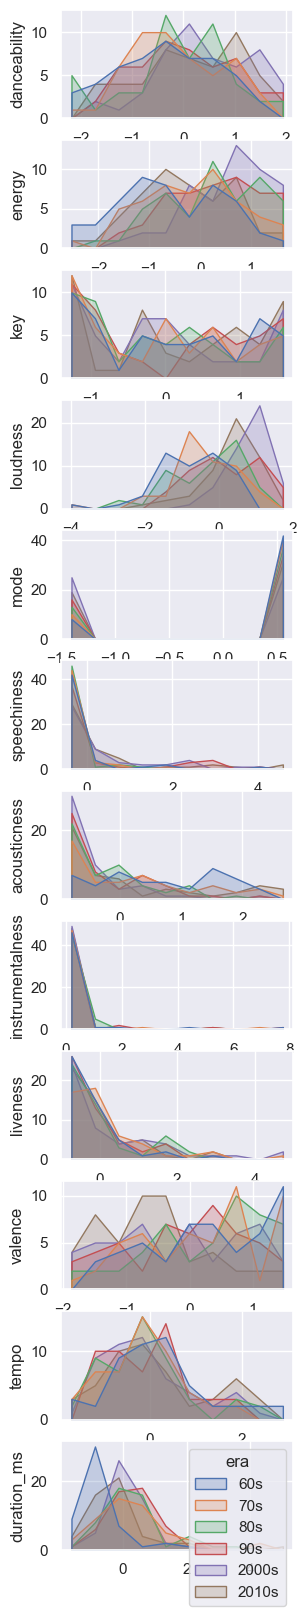

In [101]:
df = pd.read_csv(f'gs://{get_project_id()}/spotify/audio_features_by_era/data.csv')

metrics = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
 ]

df = df.set_index([i for i in df.columns if i not in metrics])
df[metrics] = StandardScaler().fit_transform(df)

f, ax = plt.subplots(len(metrics), 1, figsize = (3,20))

index = 0
for i in range(len(metrics)):
    if i == len(metrics) - 1:
        legend = True
    else: 
        legend = False
    
    sns.histplot(data = df, x = metrics[i], hue = 'era', element = 'poly', multiple = 'layer', bins = 10, ax = ax[index], legend = legend)
    ax[index].set_ylabel(metrics[i])
    ax[index].set_xlabel('')
    index += 1

plt.show()

In [102]:
def format_era(era: str) -> int:
    era = era.replace('s', '')
    if len(era) < 4:
        era = f'19{era}'
    return int(era)

df = pd.read_csv(f"gs://{get_project_id()}/spotify/audio_features_by_era/data.csv")
df['era'] = df['era'].apply(format_era)

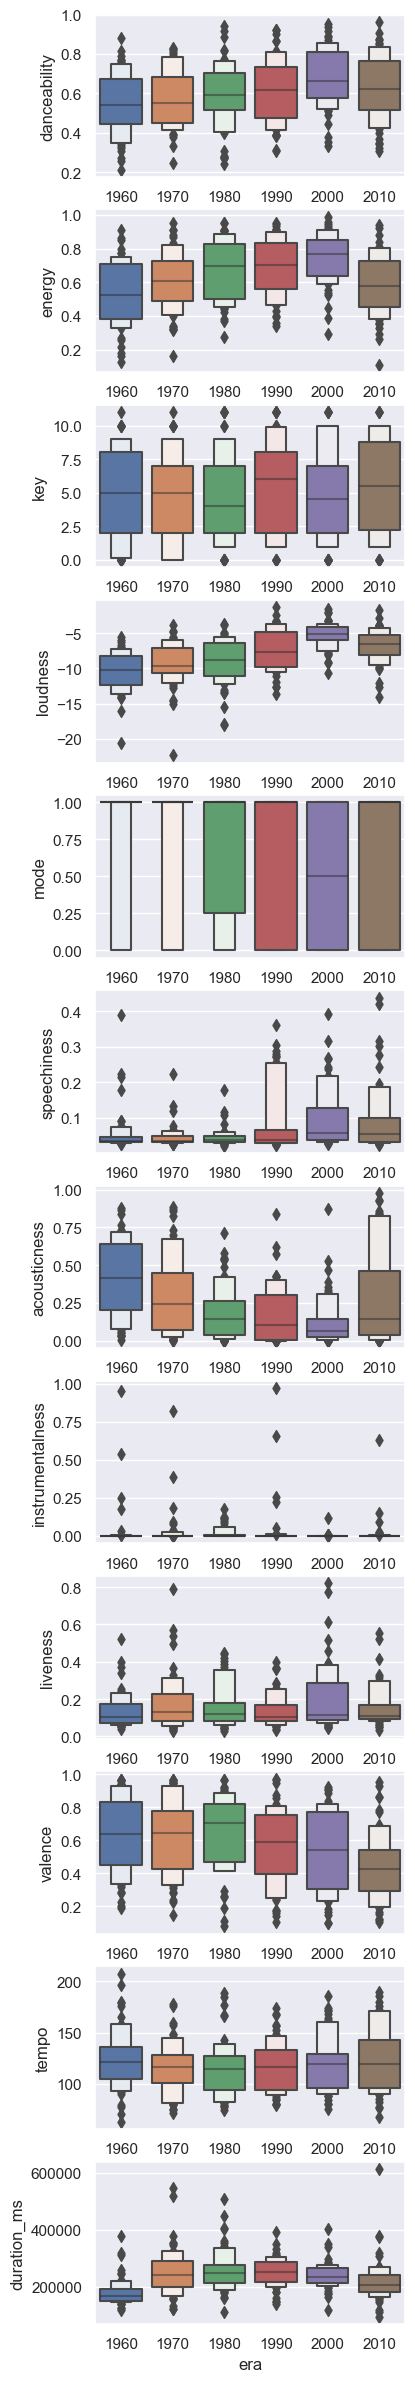

In [100]:
f, ax = plt.subplots(len(metrics),  1, figsize = (4, 30))

for i in range(len(metrics)):
    sns.boxenplot(data = df, x = 'era', y = metrics[i], ax = ax[i])
plt.show()

<AxesSubplot:>

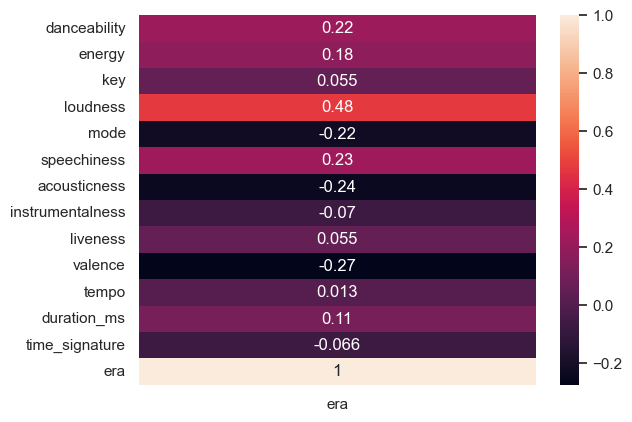

In [106]:
sns.heatmap(df.corr()[['era']],  annot = True)